# Predicting Heart Disease Using Machine Learning

This project focuses on using python-based machine learning and bata science libraries to predict if one has heart disease or not, based on given clinical attributes. 

The following approach will be taken to tackle this project:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modeling
6. Experimentation

**1. Problem Definition** 

Given clinical parameters/attributes, can we predict if one has heart disease or not?
    
**2. Data**
   
Original data came from the Cleavland data from the UCI Machine Learning Repository and is also available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci

**3. Evaluation**

Reach 95% accuracy in predicting if the patient has heart disease or not. 

**4. Features** - Exploratory Data Analysis (EDA)

Features that could be considered to determine if one has heart disease or not are the following: 
1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type

        0: Typical angina: chest pain related decrease blood supply to the heart
        1: Atypical angina: chest pain not related to heart
        2: Non-anginal pain: typically esophageal spasms (non heart related)
        3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
        
        serum = LDL + HDL + .2 * triglycerides
        above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
        
        '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results

        0: Nothing to note
        1: ST-T Wave abnormality
            
            can range from mild symptoms to severe problems
            signals non-normal heart beat
        2: Possible or definite left ventricular hypertrophy
            Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment

        0: Upsloping: better heart rate with excercise (uncommon)
        1: Flatsloping: minimal change (typical healthy heart)
        2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
        
        colored vessel means the doctor can see the blood passing through
        the more blood movement the better (no clots)
13. thal - thalium stress result
        
        1,3: normal
        6: fixed defect: used to be defect but ok now
        7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

**5. Modeling**

**6. Experiementation**

**Preparing the tools**

In [1]:
# Performing EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Model evaluation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

### Helper Functions

In [256]:
def load_file(file_name):
    '''
    Loads csv to panda dataframe.
    '''
    return pd.read_csv(file_name)
    
def file_properties(file):
    '''
    Shows the shape of the file, if there are any empty values, any duplicated values and information
    about the dataframe.
    '''
    file.info()
    print( f" \nEmpty values in file: {file.isna().sum()} \n")
    print(f"Duplicated values in file : {file.duplicated().sum()} \n")
    print(file.describe())

def clean_data (file):
    '''
    Remove duplicates and shuffle data to minimize variance and generate a better model. 
    '''
    np.random.seed(50)
    file = shuffle(file).reset_index(drop=False)
    
    
def patients_in_outlier_zone(df, col, feature):
    '''
    Identifies the mean and the outliners for a specific column.
    df = file worked on
    col = column in question, as shown in file, generally shown as an abrevation.
    feature = A name for the column that can be easily understood instead of the abrevated column name.
    eg: patients_in_outlier_zone(file_name, abrevated_col_name, actual_column_name)
    '''
    mean = df[col].mean()
    iqr = df[col].describe()['75%'] - df[col].describe()['25%']
    upper  = df[col].describe()['75%'] + 1.5*iqr
    lower = df[col].describe()['25%']-1.5* iqr
    print(f"The dataset carries values ranging from {df[col].describe()['min']} and {df[col].describe()['max']} ")
    print(f"In this {feature} distribution, mean: {mean:.2f}, \n Outliers:  {lower} and {upper}!")
    print (f"Number of patient data in the outlier zone, \n with heart disease: \
    {sum(df[col][(df[col]>upper)&(file.target==1)].value_counts())} \n without \
    heart disease : {sum(df[col][(df[col]>upper)&(file.target!=1)].value_counts())}")

    
def feature_in_cross_tab(df, col):
    '''
    Helps view features against target in a crosstab view.
    df = data file
    col = column in question
    '''
    feature_crosstab = pd.crosstab(df[col], file.target)
    feature_crosstab.columns = ["No Heart Disease", "Heart Disease"]
    return feature_crosstab
    
    
def visualize_feature_with_target(df, col, feature):
    '''
    Visualize a specific feature in the dataset against the target.
    '''
    fig, ax = plt.subplots(figsize = (6,4))
    pd.crosstab( df[col], df['target'] ).plot(kind = "bar", ax= ax, color = ['lightblue', 'lightgreen', 'green', 'orange'])
    ax.set(title = f"Heart Disease According to {feature.capitalize()}",
          ylabel = "Amount" )
    ax.legend(["No Disease", "Disease"])
    plt.xticks(rotation = 0)
    
    
def view_in_histogram(df, col, feature):
    '''
    Creating a histogram for a feature and finding outliers and getting the mean of the values without outliers.
    '''
    fig, ax = plt.subplots()
    ax.set(title = f"Distribution of Patients according to the {feature.capitalize()}",
          xlabel = feature.capitalize(),
          ylabel = "Number of Patients")
    iqr = df[col].describe()['75%'] - df[col].describe()['25%']
    upper  = df[col].describe()['75%'] + 1.5*iqr
    lower = df[col].describe()['25%']-1.5* iqr
    values = df[col][(df[col]<upper) & (df[col]>lower)] # Values without outliers
    mean_value = sum(values)/len(values) # Mean of the values within outliers
    plt.axvline(mean_value, color = "orange")
    ax.hist(df[col])
    

def scatter_plot_features(df, col1, col2):
    '''
    Plots 2 independant features in a scatter plot with regard to prevelence of the disease.
    df = dataset
    col1= 1st independant variable considered for the evaluation
    col2 = 2nd variable considered for the evaluation
    '''
    fig, ax = plt.subplots()
    no_disease = plt.scatter(df[col1][df['target']==0], df[col2][df['target']==0],
                             color = "lightBlue", label = col2)
    with_disease = plt.scatter(df[col1][df['target']==1], df[col2][df['target']==1], 
                               color = 'orange', label = col1)
    ax.set(title = (f"Relationship between {col1.capitalize()} and {col2.capitalize()} "),
           xlabel=(f"{col1.capitalize()} Limits "),
           ylabel=(f"{col2.capitalize()} Limits"))
    ax.legend([with_disease, no_disease], ["Disease", "No Disease"])
    

def score_with_gscv (model, grid):
    '''
    Calculates the score using the best parameters chosen from the best_params_with_rscv() function.
    model = model_name
    grid = the grid containing the best parameters 
    '''
    gscv = GridSearchCV(model,
                       param_grid= grid,
                       cv = 5,
                       verbose = True)
    gscv.fit(features_train, target_train)
    return gscv.score(features_test, target_test)*100


    


In [49]:
file = load_file("heart-disease.csv")

In [50]:
file.head(10)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


### Exploratoy Data Analysis (EDA)

In [51]:
# Shapes
file_properties(file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
 
Empty values in file: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0

    File has 303 entries with 14 columns. All data entries are numeric values. 

    Since there are no patient ids or unique values to identify patients, we can assume all these are unique patients and therefore assume that there are no duplicated records.

Since all the data are numeric, there's no need to for OneHotEncoder for changing data types for data analysis.

In [52]:
#Understanding how many patients in the study have heart disease and how many do not have heart disease.
target_values = file.target.value_counts()
target_values

1    165
0    138
Name: target, dtype: int64

The two data sets with the number of patients with heart disease and without heart disease are similar. 

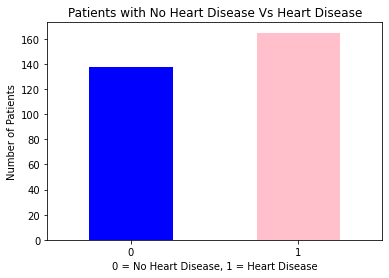

In [94]:
# Plotting patients with and without heart disease.
fig, ax = plt.subplots(figsize = (6,4))
ax= target_values.plot(kind = "bar", color = ['pink', 'blue'])
ax.set(title = "Patients with No Heart Disease Vs Heart Disease",
      xlabel = "0 = No Heart Disease, 1 = Heart Disease",
      ylabel = ("Number of Patients"))
plt.xticks(rotation = 0);

In [54]:
# Trying to understand if there are any outliners in the age group.
patients_in_outlier_zone(file, 'age', 'age')

The dataset carries values ranging from 29.0 and 77.0 
In this age distribution, mean: 54.37, 
 Outliers:  27.25 and 81.25!
Number of patient data in the outlier zone, 
 with heart disease:     0 
 without     heart disease : 0


Since the minimum and maximum ages of the patients fall within the distribution, there's no need to eliminate any records

In [55]:
#How many males and females have heart disease
feature_in_cross_tab(file, "sex")

,No Heart Disease,Heart Disease
sex,,
0,24,72
1,114,93


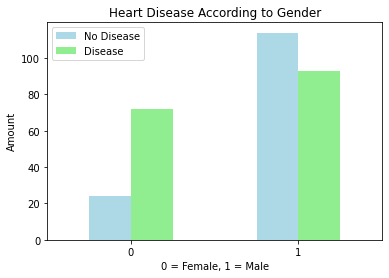

In [98]:
# Visualize prevalence of heart disease according to gender
visualize_feature_with_target(file, 'sex', 'gender');

Percentage-wise, more women in this test group have heart disease, compared to the men. 

In [100]:
feature_in_cross_tab(file, "fbs")

,No Heart Disease,Heart Disease
fbs,,
0,116,142
1,22,23


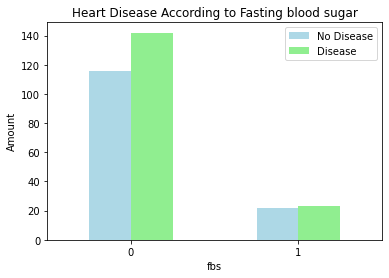

In [102]:
# Visualize prevalence of heart disease according to fasting blood sugar
visualize_feature_with_target(file, 'fbs', 'fasting blood sugar');

According to the graph, there are 50:50 chance of having disease vs no disease regardless of one's fasting blood sugar levels.

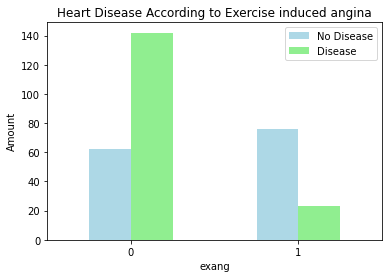

In [103]:
visualize_feature_with_target(file, 'exang', 'exercise induced angina')

According to the graph, few people with exercise induced angina develop the disease. Many people exercise induced angina do not develop heart disease. 

How is this possible? Is the data bias and not reflecting the true picture of the outside world?

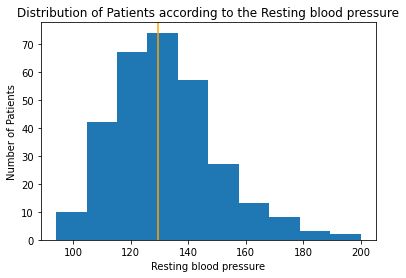

In [57]:
view_in_histogram(file, 'trestbps', 'Resting Blood Pressure')


In [58]:
# Finding how many records that are outliers in resting blood pressure have heart disease. 
patients_in_outlier_zone(file, 'trestbps', "Blood Pressure")

The dataset carries values ranging from 94.0 and 200.0 
In this Blood Pressure distribution, mean: 131.62, 
 Outliers:  90.0 and 170.0!
Number of patient data in the outlier zone, 
 with heart disease:     3 
 without     heart disease : 6


How is it that the number of patients with heart disease is less than patients without heart disease in the outlier zone of over 170mmhg resting blood pressure?

Resting blood pressure outliers hold about 3% of all the data. Do we disregard them. So should we continue with further evaluations?

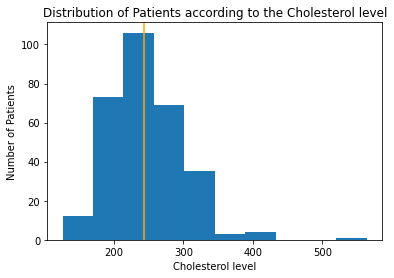

In [59]:
view_in_histogram(file, 'chol', 'Cholesterol Level')


In [60]:
patients_in_outlier_zone(file, 'chol', 'Cholesterol Levels')

The dataset carries values ranging from 126.0 and 564.0 
In this Cholesterol Levels distribution, mean: 246.26, 
 Outliers:  115.75 and 369.75!
Number of patient data in the outlier zone, 
 with heart disease:     3 
 without     heart disease : 2


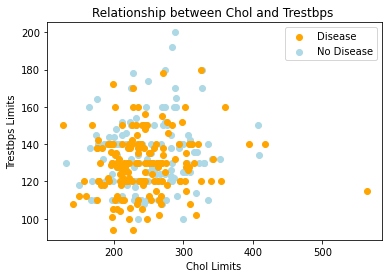

In [61]:
# Visualize relationship in patients with regard to their cholesterol levels and max heart rate 
scatter_plot_features(file, 'chol', 'trestbps')

General norm is that when cholesterol levels, go up, there's higher potential for developing heart disease. Same applies to resting blood pressure levels. 
Looking at the diagram, the results seem to contradict the general norm. Where does this disconnect come from? Is it inaccurate data reporting or not sufficient information?

In [62]:
# Understanding the relationship between chest pains and prevalence of heart disease
feature_in_cross_tab(file, 'cp')

,No Heart Disease,Heart Disease
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


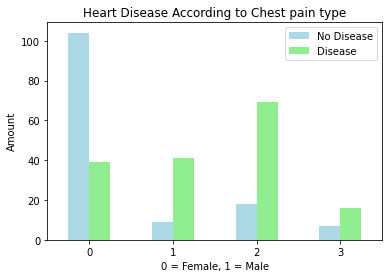

In [63]:
visualize_feature_with_target(file, 'cp', 'chest pain type')

CP,

    0: Typical angina: chest pain related decrease blood supply to the heart
    1: Atypical angina: chest pain not related to heart
    2: Non-anginal pain: typically esophageal spasms (non heart related)
    3: Asymptomatic: chest pain not showing signs of disease
        
According to this graph, non heart related pain somehow have a high correlation with patient having heart disease. This is a good time to talk to a subject matter expert and understand if the data retrieved need revision or understand where the disconnect comes from.


In [64]:
# Understand correlation matrix between features
file.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


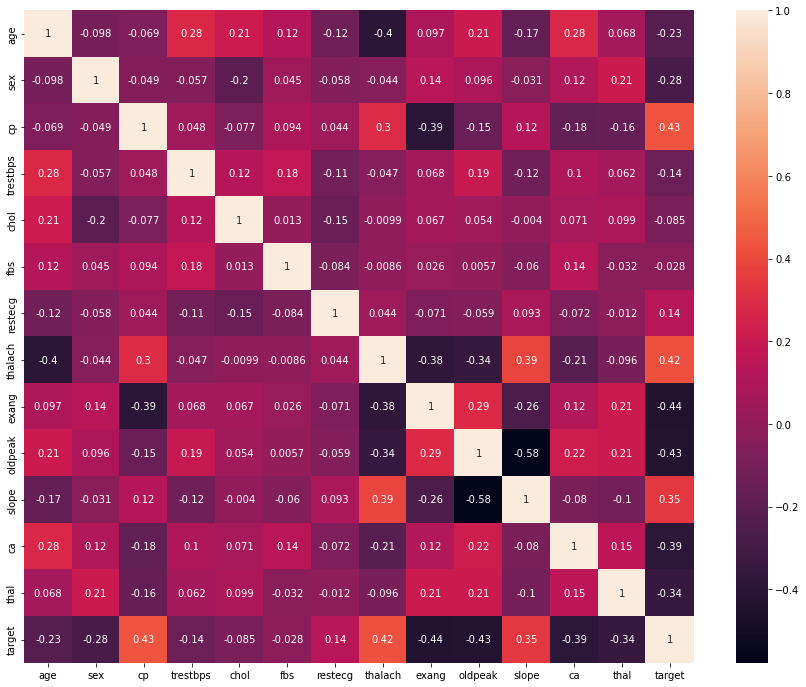

In [104]:
# Visualize correlation betwen features
fig, ax = plt.subplots(figsize = (15,12))
ax = sns.heatmap(file.corr(), annot = True)

### 5. Modeling

The focus of this project is given the clinical features, predict if a patient has heart disease or not. 
Obtaining over 95% accuracy will be considered a successful project.

**How Models Were Chosen**
    
For this project, we'll use RandomForestClassifier, LogisticRegression and KNeighborsClassifier. 

Because focusing on recall and lowering the false negative results and finding the patients with more vulnerability to developing heart disease are important aspact, and since all columns are numeric, LogisticRegression is a great model to consider for this project.
Since the features used for this project are non linear, and its generally faster than other classification models, we'll use KNeighborsClassifier for this project. Also, since RandomForestClassifier is more of accuracy focused and it has the ability to look at individual decision trees and capture more complex features, it would be a great fit as well. 

#### Splitting Datasets and Fitting Models the Data

In [195]:
# Defining X and y
features = file.drop("target", axis = 1)
target = file.target

# Splitting data
np.random.seed(42)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2)


# Initiating models in a dictionary
models = {"RandomForestClassifier" :RandomForestClassifier(),
         "KNN" : KNeighborsClassifier(),
         "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000), # Using the suggestion to avoid convergence warning
         "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric = 'logloss')}

# Holds the model scores
model_scores = {}

def fit_and_score(model_dictionary, X_train, X_test, y_train, y_test):
    '''
    Fits the training data to the model and put the model scores in the model_scores dictionary.
    model_dictionary = where the models are initiated
    '''
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)*100
    return model_scores


fit_and_score(models, features_train, features_test, target_train, target_test)

{'RandomForestClassifier': 85.24590163934425,
 'KNN': 68.85245901639344,
 'Logistic Regression': 86.88524590163934,
 'XGBoost': 81.9672131147541}

#### Cross validated RandomForestClassifier

In [110]:
cross_val_score(RandomForestClassifier(), features, target, cv = 5, scoring = 'recall').mean()

0.8424242424242424

Maximum value: 86.89%


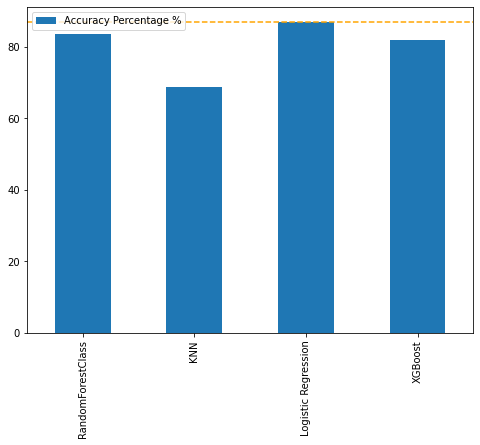

In [168]:
print(f"Maximum value: {max(model_scores.values()):.2f}%")

# Creating a bar graph showing the model scores
accuracy_scores = pd.DataFrame(model_scores, index = ["Accuracy Percentage %"])
accuracy_scores.T.plot(kind = "bar", figsize = (8,6))
plt.axhline(max(model_scores.values()), linestyle = "--", c = "orange");

    

Looking at the graph, we'll move forward with hyperparameter tuning for RandomForestClassifier and Logistic Regression and XGBoostClassifier

### Hyperparameter Tuning with RandomizedSearchCV And GridSearchCV

In [164]:
# Grid for RandomForstClassifier
rfc_grid = {"n_estimators": [200,300,500],
           "max_depth": [None, 3, 5,8, 10],
           "min_samples_split": [2, 4,6,8],
           "min_samples_leaf": [2,4,6,8],
           "max_features":['auto', 'sqrt']}

# Grid for Logistic Regression
lr_grid = {"C": np.logspace(-4, 4, 30),
         "solver": ["liblinear", "sag", "saga"],
          "penalty":['l1', 'l2']}

# Dictionary to hold grids
grids = {RandomForestClassifier(): rfc_grid,
         LogisticRegression(): lr_grid}

# Hold the best parameters of the models
best_grids = {}

def best_params_with_rscv():
    '''
    Shows the best parameter selection from the grid which gives the best accuracy scores. 
    model = model name
    grids = grid which contains lists of parameters tested.
    '''
    np.random.seed(42)
    for name, grid in grids.items():
        rscv = RandomizedSearchCV(name,
                                 param_distributions= grid,
                                 cv = 5, 
                                 verbose = True,
                                 n_iter = 20)
        rscv.fit(features_train, target_train)
        best_grids[name] = rscv.best_params_

    return best_grids

# Get the best parameters
best_params_with_rscv()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\users\Charles\Desktop\sample_project_1\env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\users\Charles\Desktop\sample_project_1\env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\users\Charles\Desktop\sample_project_1\env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\users\Charles\Desktop\sample_project_1\env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\users\Charles\Desktop\sample_project_1\env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\us

{RandomForestClassifier(): {'n_estimators': 300,
  'min_samples_split': 4,
  'min_samples_leaf': 6,
  'max_features': 'sqrt',
  'max_depth': 3},
 LogisticRegression(): {'solver': 'liblinear',
  'penalty': 'l2',
  'C': 0.20433597178569418}}

**Accuracy using best_params_ for RandomForestClassifier**

In [222]:
# Using best parameters of RandomForestClassifier to score the testing data 
best_rfc_grid = {'n_estimators': [300],
                 'min_samples_split' :  [4],
                 'min_samples_leaf': [6],
                 'max_features' :['sqrt'],
                 'max_depth': [3]}
                                     
best_rfc_score = score_with_gscv(RandomForestClassifier(), best_rfc_grid)
best_rfc_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


86.88524590163934

**Accuracy using best_params_ for LogisticRegression**

In [219]:
best_lg_grid = {'solver': ['liblinear'],
                'penalty':['l2'],
                'C': [0.20433597178569418]}

best_lg_score = score_with_gscv(LogisticRegression(), best_lg_grid)
best_lg_score

Fitting 5 folds for each of 1 candidates, totalling 5 fits


88.52459016393442

**Accuracy Score Prior to Parameter tuning**

In [221]:
model_scores

{'RandomForestClassifier': 85.24590163934425,
 'KNN': 68.85245901639344,
 'Logistic Regression': 86.88524590163934,
 'XGBoost': 81.9672131147541}

**Visualize Before and After Parameter Tuning**

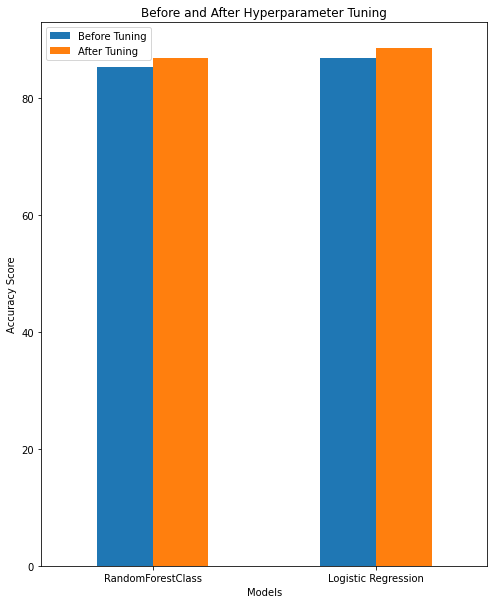

In [249]:
tuned_data = pd.DataFrame(index = ['RandomForestClass', 'Logistic Regression'], 
                          data = [[model_scores.get('RandomForestClassifier'), best_rfc_score], [model_scores.get('Logistic Regression') , best_lg_score]],
                          columns = ['Before Tuning', 'After Tuning'])
fig, ax = plt.subplots(figsize = (8,10))

ax = tuned_data.plot(kind = 'bar', ax = ax)
ax.set(title = 'Before and After Hyperparameter Tuning', 
      xlabel = 'Models',
      ylabel = 'Accuracy Score')
plt.xticks(rotation = 0);

After hyperparameter tuning, we reached accuracy of 88.52% with Logistic Regression model. Prior to tuning, it was 86.88%.


RandomForestClassifier model produced 83.60% accuracy. Using RandomizedSearchCV, and finding the best parameters and hyperparameter tuning using GridSearchCV, we reached 86.88% accuracy.

Best parameters for LogisticRegression were : {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.20433597178569418}
      

### Evaluating the LogisticRegression Model Beyond Accuracy

Here, we'll look at the following to evaluate the model.
1. ROC curve
2. Confusion Matrix
3. Classification Report
4. Precision
5. Recall 
6. F1-score

**1. LogisticRegression - ROC Curve**

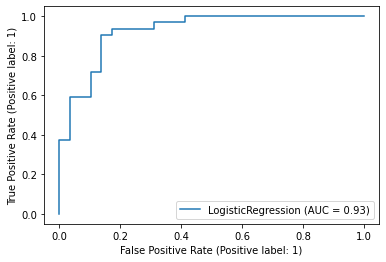

In [252]:
#ROC curve for LogisticRegression model using the best_parameters_

lr_model = LogisticRegression(solver = 'liblinear',
                               penalty = 'l2',
                               C =  0.20433597178569418)
lr_model.fit(features_train, target_train)
RocCurveDisplay.from_estimator(lr_model, features_test, target_test );

The area under the curve (AUC) in LogisticRegression model is 0.93 which is great.

This indicates that there’s only little chance for a patient to be falsely positive. 

Certainly there’s room for improvement.


**2. Confusion Matrix**

In [76]:
confusion_matrix(target_test, target_preds)

array([[25,  4],
       [ 3, 29]], dtype=int64)

Visualize the true positives and false nagatives

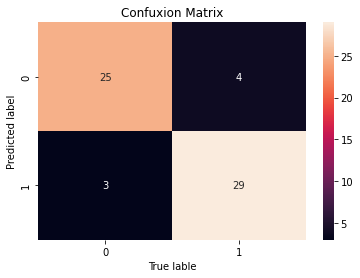

In [255]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(target_test, target_preds), annot = True)
plt.xlabel("True lable")
plt.ylabel("Predicted label")
plt.title("Confuxion Matrix");
    


True positive: False positive  = 29:3 -~ 10:1 

Looking at the data, it is most important to focus identifying patients with potential for developing heart disease. Therefore, for this project, reducing the false negative values (truly have a higher risk, yet predicts as not) is more important than reducing false positives (model predicts are high risk when they're not). 

Hense we recall is a important feature to focus for this heart disease project.

Recall = TP / TP + FN  = 29 / ( 29 + 4 ) = 0.8787

**3. Classification Report**

In [78]:
print(classification_report(target_test, target_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



**4.  LogisticRegression - Cross Validated Precision, Recall and f1-Scores for the Model**

        Accuracy   Precision    Recall   F1_score
Scores   0.844699    0.820794  0.921212  0.867301


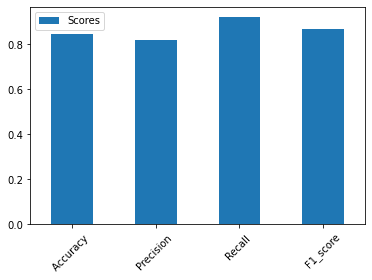

In [266]:
cv_accuracy = cross_val_score(lr_model, features, target, cv = 5, scoring = 'accuracy').mean()
cv_precision = cross_val_score(lr_model, features, target, cv = 5, scoring = 'precision').mean()
cv_recall = cross_val_score(lr_model, features, target, cv = 5, scoring = 'recall').mean()
cv_f1 = cross_val_score(lr_model, features, target, cv = 5, scoring = 'f1').mean()

cv_metrics = pd.DataFrame({"Accuracy ": cv_accuracy, 
                              "Precision ":cv_precision, 
                              "Recall ": cv_recall, 
                              "F1_score" : cv_f1},
                               index = ["Scores"])
print(cv_metrics)
cv_metrics.T.plot(kind = "bar")
plt.xticks(rotation= 45);

Recall obtained through cross validated data of 0.921 is significantly higher than evaluating the data once which hs 0.89. Therefore, crossvalidated data provides better validity in analyzing the dataset. 

**5. Feature Importance Using Logistic Regression Model**

Finding out the relative importance of features in the dataset when determining the predictions of the chosen LogisticRegression model.

In [80]:
score_with_gscv(LogisticRegression(), best_lg_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
 score is 88.52459016393442


In [81]:
# Check the coefficience for each column
lr_model.coef_

array([[ 0.00529544, -1.07322394,  0.72277886, -0.01184936, -0.00190032,
         0.07236462,  0.40912623,  0.02528457, -0.73138905, -0.59561194,
         0.54564492, -0.70203144, -0.76994228]])

In [82]:
file.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [83]:
#Match column name to coefficience.
column_coef = dict(zip(file.columns, lr_model.coef_[0]))
column_coef

{'age': 0.005295438047334286,
 'sex': -1.0732239361933191,
 'cp': 0.7227788637559055,
 'trestbps': -0.011849359026323175,
 'chol': -0.001900319998679754,
 'fbs': 0.07236462311065912,
 'restecg': 0.4091262280831722,
 'thalach': 0.025284571415140688,
 'exang': -0.7313890450806052,
 'oldpeak': -0.5956119353474224,
 'slope': 0.5456449245534262,
 'ca': -0.7020314413564828,
 'thal': -0.7699422844140955}

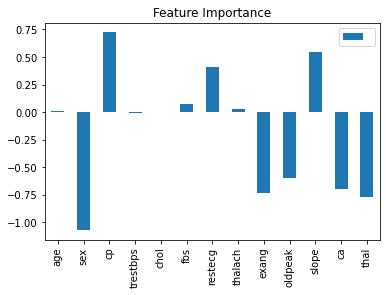

In [272]:
#Visualize the feature importance
feature_importance = pd.DataFrame(column_coef, index= [''])
feature_importance.T.plot(kind = "bar")
plt.title('Feature Importance');

The project can be improved by obtaining more random data to represent the general public, trying other predictive models, and tuning different hyperparameters to obtain better results.

Also consulting with subject matter expert to discuss the finding and understanding where the disconnect with the real world would give a better sense of the data used and help gather more random dataset for the future projects. 